# SQL

In this project, I will work with the StackOverflow database — a question-and-answer service for programming-related topics. StackOverflow is similar to a social network — users ask questions, reply to posts, leave comments, and upvote other answers.
I will work with a version of the database that contains data about posts from 2008, but in the tables, I will also find information about more recent ratings that these posts received.

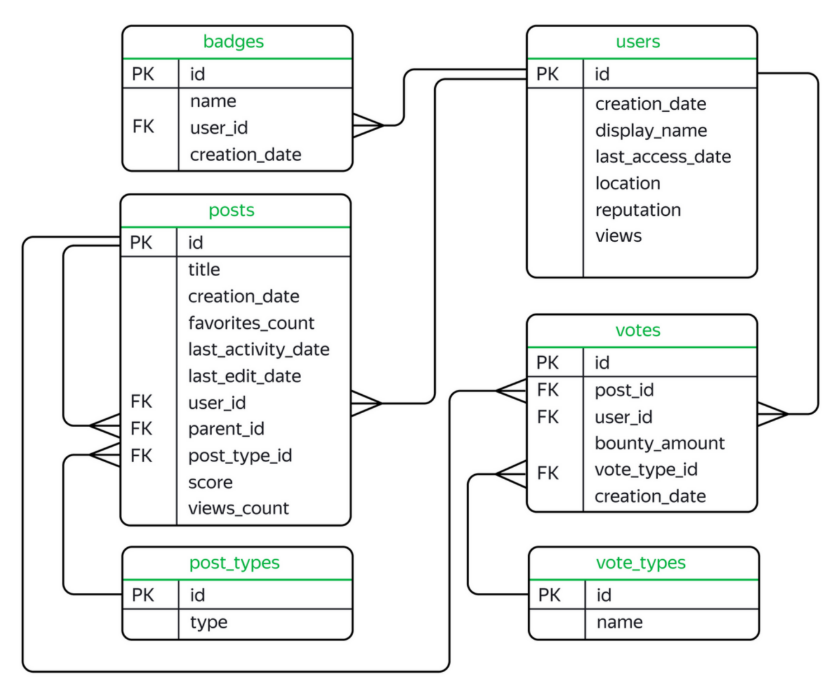

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

In [9]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-analyst-advanced-sql'
}

In [10]:
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

Let's find the number of questions that have scored more than 300 points or have been added to "Bookmarks" at least 100 times.

In [11]:
query = '''
SELECT COUNT(p.id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.post_types AS p_t ON p.post_type_id = p_t.id
WHERE p_t.type = 'Question'
      AND (p.score > 300 OR p.favorites_count >= 100);
'''

In [12]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,count
0,1355


What is the average number of questions asked per day from November 1st to November 18th, 2008, inclusive? Round the result to the nearest whole number.

In [13]:
query = '''
WITH day_by_day AS (
    SELECT CAST(DATE_TRUNC('day', p.creation_date) AS DATE) AS day,
           COUNT(p.id) as count
    FROM stackoverflow.posts AS p
    JOIN stackoverflow.post_types AS p_t ON p.post_type_id = p_t.id
    WHERE p_t.type = 'Question'
      AND (p.creation_date BETWEEN '2008-11-01' AND '2008-11-19')
    GROUP BY CAST(DATE_TRUNC('day', p.creation_date) AS DATE)
    ORDER BY day
)
SELECT ROUND(SUM(count)/EXTRACT(DAY FROM AGE('2008-11-19'::date, '2008-11-01'::date)), 0)
FROM day_by_day;
'''

In [14]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,round
0,383.0


How many users received badges on the day of registration? Display the number of unique users.

In [15]:
query = '''
SELECT COUNT(DISTINCT u.id)
FROM stackoverflow.users AS u
JOIN stackoverflow.badges AS b ON u.id = b.user_id
WHERE b.creation_date::date = u.creation_date::date
'''

In [16]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,count
0,7047


How many unique posts by the user named Joel Coehoorn received at least one vote?

In [17]:
query = '''
SELECT COUNT(DISTINCT p.id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u ON p.user_id = u.id
WHERE u.display_name = 'Joel Coehoorn'
  AND p.score > 0;
'''

In [18]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,count
0,633


Export all fields from the `vote_types` table. Add a column `rank` to the table, which will contain the row numbers in reverse order. The table should be sorted by the `id` field.

In [19]:
query = '''
SELECT *,
       ROW_NUMBER() OVER (ORDER BY id DESC) AS rank
FROM stackoverflow.vote_types
ORDER BY id DESC;
'''

In [20]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,id,name,rank
0,15,ApproveEditSuggestion,1
1,14,ModeratorReview,2
2,13,InformModerator,3
3,12,Spam,4
4,11,Undeletion,5


Select the 10 users who cast the most "Close" votes. Display a table with two fields: user ID and the number of votes. Sort the data first by the number of votes in descending order, then by user ID in descending order.

In [21]:
query = '''
SELECT u.id,
       COUNT(v_t.id)
FROM stackoverflow.users AS u
JOIN stackoverflow.votes AS v ON u.id = v.user_id
JOIN stackoverflow.vote_types AS v_t ON v.vote_type_id = v_t.id
WHERE v_t.name = 'Close'
GROUP BY u.id
ORDER BY COUNT(v_t.id) DESC, u.id DESC
LIMIT 10;
'''

In [22]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,id,count
0,20646,36
1,14728,36
2,27163,29
3,41158,24
4,24820,23


Select the top 10 users by the number of badges received between November 15th and December 15th, 2008, inclusive. Display several fields:

In [23]:
query = '''
SELECT u.id,
       COUNT(b.id) AS badge_count,
       DENSE_RANK() OVER (ORDER BY COUNT(b.id) DESC) AS rank
FROM stackoverflow.users AS u
JOIN stackoverflow.badges AS b ON u.id = b.user_id
WHERE b.creation_date BETWEEN '2008-11-15' AND '2008-12-16'
GROUP BY u.id
ORDER BY badge_count DESC, u.id ASC
LIMIT 10;
'''

In [24]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,id,badge_count,rank
0,22656,149,1
1,34509,45,2
2,1288,40,3
3,5190,31,4
4,13913,30,5


What is the average number of points each user's post receives?

In [25]:
query = '''
SELECT p.title,
       p.user_id,
       p.score,
       ROUND(AVG(p.score) OVER (PARTITION BY p.user_id), 0) AS avg_score
FROM stackoverflow.posts AS p
WHERE p.title IS NOT NULL
  AND p.score != 0;
'''

In [26]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,title,user_id,score,avg_score
0,Diagnosing Deadlocks in SQL Server 2005,1,82,573.0
1,How do I calculate someone's age in C#?,1,1743,573.0
2,Why doesn't IE7 copy <pre><code> blocks to the...,1,37,573.0
3,Calculate relative time in C#,1,1348,573.0
4,Wrapping StopWatch timing with a delegate or l...,1,92,573.0


Display the titles of posts written by users who have received more than 1000 badges. Posts without titles should not be included in the list.

In [27]:
query = '''
WITH badge_over_1000 AS (
    SELECT p.title AS title,
           COUNT(b.id) AS badge_count
    FROM stackoverflow.posts AS p
    JOIN stackoverflow.users AS u ON p.user_id = u.id
    JOIN stackoverflow.badges AS b ON u.id = b.user_id
    WHERE p.title IS NOT NULL
    GROUP BY p.title
)
SELECT title
FROM badge_over_1000
WHERE badge_count > 1000;
'''

In [28]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,title
0,Project management to go with GitHub
1,What are the correct version numbers for C#?
2,What's the hardest or most misunderstood aspec...
3,What's the strangest corner case you've seen i...


Calculate the daily increase in new users in November 2008.

In [29]:
query = '''
WITH daily_counts AS (
    SELECT
        DATE_TRUNC('day', creation_date) AS day,
        COUNT(id) AS daily_count
    FROM
        stackoverflow.users
    WHERE
        DATE_TRUNC('day', creation_date) BETWEEN '2008-11-01' AND '2008-11-30'
    GROUP BY
        DATE_TRUNC('day', creation_date)
)
SELECT
    ROW_NUMBER() OVER (ORDER BY day) AS day_number,
    daily_count,
    SUM(daily_count) OVER (ORDER BY day) AS costs_cum
FROM
    daily_counts
ORDER BY
    day_number;
'''

In [30]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,day_number,daily_count,costs_cum
0,1,34,34.0
1,2,48,82.0
2,3,75,157.0
3,4,192,349.0
4,5,122,471.0


For each user who has written at least one post, find the interval between registration and the time of the first post creation.

In [31]:
query = '''
SELECT
    u.id AS user_id,
    MIN(p.creation_date) - u.creation_date AS time_difference
FROM
    stackoverflow.users AS u
JOIN
    stackoverflow.posts AS p
ON
    u.id = p.user_id
GROUP BY
    u.id, u.creation_date
HAVING
    COUNT(p.id) > 0;
'''

In [32]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,user_id,time_difference
0,24174,0 days 06:38:11
1,282,29 days 02:45:21
2,3980,24 days 10:55:03
3,25511,0 days 00:28:23
4,7691,0 days 05:07:46


The total number of views for posts published in each month of 2008, sorted in descending order.

In [33]:
query = '''
SELECT
    CAST(DATE_TRUNC('month', p.creation_date) AS DATE) AS month,
    SUM(p.views_count) AS total_views
FROM
    stackoverflow.posts AS p
WHERE
    EXTRACT(YEAR FROM p.creation_date) = 2008
GROUP BY
    CAST(DATE_TRUNC('month', p.creation_date) AS DATE)
ORDER BY
    total_views DESC;
'''

In [34]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,month,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083


The most active users who provided more than 100 answers in the first month after registration.


In [35]:
query = '''
SELECT u.display_name, 
       COUNT(DISTINCT p.user_id) AS post_count
FROM stackoverflow.posts AS p
JOIN stackoverflow.post_types AS pt ON pt.id = p.post_type_id
JOIN stackoverflow.users AS u ON u.id = p.user_id
WHERE  p.creation_date::date <= u.creation_date::date + INTERVAL '1 month'
   AND p.creation_date::date >= u.creation_date::date
AND pt.type = 'Answer'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name;
'''

In [36]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,display_name,post_count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8


The number of posts per month in 2008 for users who registered in September 2008 and made a post in December.

In [37]:
query = '''
SELECT
    CAST(DATE_TRUNC('month', p.creation_date) AS DATE) AS month,
    COUNT(DISTINCT p.id) AS posts_count
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u ON p.user_id = u.id
WHERE p.user_id IN (
    SELECT DISTINCT user_id
    FROM stackoverflow.posts
    WHERE creation_date >= '2008-12-01'
      AND creation_date < '2009-01-01'
)
AND u.creation_date >= '2008-09-01'
AND u.creation_date < '2008-10-01'
GROUP BY CAST(DATE_TRUNC('month', p.creation_date) AS DATE)
ORDER BY month DESC;
'''

In [38]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,month,posts_count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


User ID, post creation date, number of views, and cumulative sum of views.

In [39]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

In [40]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


The average number of days users interacted with the platform from December 1st to December 7th, 2008.

In [41]:
query = '''
WITH UserDays AS (
    SELECT
        p.user_id,
        DATE(p.creation_date) AS post_day
    FROM stackoverflow.posts AS p
    WHERE p.creation_date >= '2008-12-01'
      AND p.creation_date <= '2008-12-07'
    GROUP BY p.user_id, DATE(p.creation_date)
),
UserDaysCount AS (
    SELECT
        user_id,
        COUNT(DISTINCT post_day) AS days_count
    FROM UserDays
    GROUP BY user_id
)
SELECT ROUND(AVG(days_count)) AS average_days
FROM UserDaysCount;
'''

In [42]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,average_days
0,2.0


The monthly change in the number of posts from September 1st to December 31st, 2008.

In [43]:
query = '''
WITH monthly_posts AS (
    SELECT DATE_PART('month', p.creation_date) AS month_num,
           COUNT(p.id) AS post_count
    FROM stackoverflow.posts p
    WHERE p.creation_date BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY DATE_PART('month', p.creation_date)
    ORDER BY month_num
)
    SELECT month_num,
           post_count,
           ROUND(
                 CASE WHEN prev_post_count = 0 THEN 0
                 ELSE (post_count - prev_post_count) * 100.0 / prev_post_count
                 END,
                 2
                 ) AS percent_change
FROM (
    SELECT
        *,
        LAG(post_count, 1) OVER (ORDER BY month_num) AS prev_post_count
    FROM monthly_posts
) t;
'''

In [44]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,month_num,post_count,percent_change
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


The user with the most posts and their activity for October 2008.

In [45]:
query = '''
WITH TopUser AS (
    SELECT user_id
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT(*) DESC
    LIMIT 1
),
OctoberPosts AS (
    SELECT p.creation_date
    FROM stackoverflow.posts p
    JOIN TopUser tu ON p.user_id = tu.user_id
    WHERE p.creation_date >= '2008-10-01'
      AND p.creation_date < '2008-11-01'
),
WeeklyPosts AS (
    SELECT
        EXTRACT(WEEK FROM creation_date) AS week_number,
        MAX(creation_date) AS last_post_date
    FROM OctoberPosts
    GROUP BY EXTRACT(WEEK FROM creation_date)
    ORDER BY week_number
)
SELECT week_number, last_post_date
FROM WeeklyPosts;
'''

In [46]:
try:
    df = pd.read_sql_query(query, con=engine)
    display(df.head())
except Exception as e:
    display(f"Error: {e}")

,week_number,last_post_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
